# DataApplication Lab baseline
## 比赛: M5 时序预测


本 NoteBook 是 Kaggle M5 时序预测比赛的 Baseline，主要使用机器学习的建模方式进行时序的建模
和预测。

- 特征工程来参考：https://www.kaggle.com/kneroma/-m5-first-public-notebook-under-0-50
- groupKfold参考：https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv


- **BaseLine步骤**：    
                        1. 数据分析 EDA
                        2. 特征工程
                        3. 模型调参
                        4. stacking

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

- 缺陷：
 1. groupKfold参考kernel的线上分数是0.53，但是现在我们single model部分提交的线上结果分数达到4，要回头认真比对groupKfold
 2. 在调参过程中也要更改folds=groupKfold。

---

---
## 1、数据分析

为了节约时间，我们直接对我们后面建模有用的结果进行分析，关于数据的详细分析可以参考 [EDA](https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda)

- 查看 sales 数据前几行
- 查看 sales 数据聚合结果趋势
- 查看 sales 数据标签分布

In [ ]:
import numpy as np
from scipy import sparse
import pandas as pd
import lightgbm as lgb
import re
import string
import time
import seaborn as sns
import itertools
import sys

from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gc
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
from sklearn import metrics

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',100)

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/My\ Drive/colab/kaggle_M5/m5-forecasting-accuracy/ /content/

In [ ]:
sale_data = pd.read_csv('/content/m5-forecasting-accuracy/sales_train_validation.csv')

In [ ]:
print(sale_data.shape)
sale_data.head(5)

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

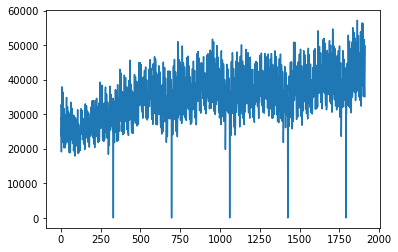

In [ ]:
plt.plot(total_sum)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


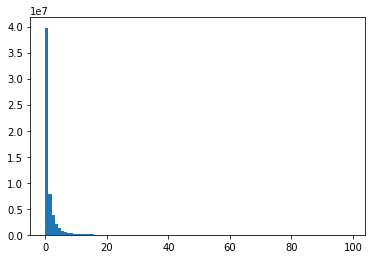

In [ ]:
plt.hist(day_data[day_data<100].values.reshape(-1),bins=100);

---
## 2、特征工程

选定机器学习的建模方案，核心思想是对时间序列抽取窗口特征。

<img src="机器学习建模.jpg" style="width:1100px;height:500px;float:center">



抽取窗口特征：

- 前7天
- 前28天
- 前7天均值
- 前28天均值

关联其他维度信息

- 日期
- 价格

In [ ]:
# helper functions to reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def create_train_data(train_start=750,test_start=1800,is_train=True):
    """
    traing_start: 取多长的数据进行训练, 从第750个到1931个
    test_start: 取多长的数据进行预测
    """
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据
    price_data = pd.read_csv('/content/m5-forecasting-accuracy/sell_prices.csv',dtype=PRICE_DTYPES)
    print(f"price data shape is {price_data.shape}")
    # 加载cal数据
    cal_data = pd.read_csv('/content/m5-forecasting-accuracy/calendar.csv',dtype=CAL_DTYPES)
    print(f"calender data shape is {cal_data.shape}")
    # 加载sale数据
    sale_data = pd.read_csv('/content/m5-forecasting-accuracy/sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)
    print(f"sale data shape is {sale_data.shape}")


    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    # 注意提交格式里有一部分为空
    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    print(f'sale data shape is {sale_data.shape} after melt')
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    print(f'sale data shape is {sale_data.shape} after merging with cal_data')
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    print(f'sale data shape is {sale_data.shape} after merging with price_data')
    return sale_data

In [ ]:
sale_train_data = create_train_data(train_start=1500,is_train=True)
sale_test_data = create_train_data(is_train=False)

price data shape is (6841121, 4)
calender data shape is (1969, 14)
sale data shape is (30490, 420)
sale data shape is (12622860, 8) after melt
sale data shape is (12622860, 21) after merging with cal_data
sale data shape is (12567124, 22) after merging with price_data
price data shape is (6841121, 4)
calender data shape is (1969, 14)
sale data shape is (30490, 120)
sale data shape is (5183300, 8) after melt
sale data shape is (5183300, 21) after merging with cal_data
sale data shape is (5182803, 22) after merging with price_data


In [ ]:
sale_train_data.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
12567119,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98
12567120,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
12567121,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
12567122,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00
12567123,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [ ]:
sale_test_data.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1800,0.0,2016-01-02,11549,2,1,1,2016,0,0,0,0,1.0,0.0,1.0,8.26
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1801,1.0,2016-01-03,11549,3,2,1,2016,0,0,0,0,1.0,1.0,1.0,8.26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1802,2.0,2016-01-04,11549,1,3,1,2016,0,0,0,0,1.0,0.0,0.0,8.26
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1803,0.0,2016-01-05,11549,5,4,1,2016,0,0,0,0,1.0,1.0,1.0,8.26
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1804,1.0,2016-01-06,11549,6,5,1,2016,0,0,0,0,1.0,1.0,1.0,8.26


In [ ]:
sale_test_data.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
5182798,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,3.98
5182799,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.28
5182800,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.28
5182801,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.00
5182802,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.00


In [ ]:
sale_data = pd.concat([sale_train_data,sale_test_data])

print ("Full Sale Data set created.")

Full Sale Data set created.


In [ ]:
print(sale_data.shape)
sale_data.columns

(17749927, 22)


Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [ ]:
sale_data.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1500,0.0,2015-03-08,11506,3,2,3,2015,0,0,0,0,1.0,0.0,1.0,8.26
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1501,0.0,2015-03-09,11506,1,3,3,2015,0,0,0,0,1.0,1.0,1.0,8.26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1502,0.0,2015-03-10,11506,5,4,3,2015,0,0,0,0,1.0,0.0,0.0,8.26
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1503,1.0,2015-03-11,11506,6,5,3,2015,0,0,0,0,0.0,1.0,1.0,8.26
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1504,1.0,2015-03-12,11506,4,6,3,2015,0,0,0,0,0.0,1.0,1.0,8.26


In [ ]:
sale_data.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
5182798,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,3.98
5182799,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.28
5182800,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.28
5182801,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.00
5182802,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.00


In [ ]:
# 可以在这里加入更多的特征抽取方法
# 获取7天前的数据，28天前的数据
# lags = [7, 28], 因为验证集28天现在sale为空，我们对验证集不能取lag=7
lags = [28]
lag_cols = [f"lag_{lag}" for lag in lags]

# 如果是测试集只需要计算一天的特征，减少计算量
# 注意训练集和测试集特征生成要一致

for lag, lag_col in zip(lags, lag_cols):
    sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)

# 将获取7天前的数据，28天前的数据做移动平均
# wins = [7, 28]
# use the rolling windows from 'simple GroupKFold CV'
wins = [7, 15, 30, 90]


for win in wins :
    for lag,lag_col in zip(lags, lag_cols):
        sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()) 
        sale_data[f'rstd_{lag}_{win}'] = sale_data[['id', lag_col]].groupby('id')[lag_col].transform(lambda x: x.rolling(win).std())

sale_data = reduce_mem_usage(sale_data)

# 处理时间特征
# 有的时间特征没有，通过datetime的方法自动生成
date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
        "dayofweek": "dayofweek",
        "dayofyear": "dayofyear"
    }

for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in sale_data.columns:
        sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
    else:
        sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")

Mem. usage decreased to 1303.43 Mb (50.6% reduction)


In [ ]:
sale_data.shape

(17749927, 36)

In [ ]:
sale_data[(sale_data['date'] >= '2016-01-25') & (sale_data['date'] <= '2016-05-22')]

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,rmean_28_7,rstd_28_7,rmean_28_15,rstd_28_15,rmean_28_30,rstd_28_30,rmean_28_90,rstd_28_90,week,quarter,mday,dayofweek,dayofyear
9731745,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1823,0.0,2016-01-25,11552,1,3,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.571289,1.133789,0.799805,1.082031,0.700195,0.952148,0.611328,0.843750,4,1,25,0,25
9731746,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1824,1.0,2016-01-26,11552,5,4,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.856934,1.214844,0.933105,1.099609,0.700195,0.952148,0.600098,0.818359,4,1,26,1,26
9731747,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1825,1.0,2016-01-27,11552,6,5,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.714355,0.951172,1.000000,1.133789,0.700195,0.952148,0.611328,0.830566,4,1,27,2,27
9731748,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1826,1.0,2016-01-28,11552,4,6,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,1.0,0.856934,0.899902,1.066406,1.099609,0.733398,0.944336,0.611328,0.830566,4,1,28,3,28
9731749,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1827,0.0,2016-01-29,11552,0,7,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.856934,0.899902,0.866699,0.990234,0.700195,0.952148,0.611328,0.830566,4,1,29,4,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481513,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1941,NaN,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,0.571289,0.786621,0.866699,1.187500,0.866699,1.136719,0.899902,0.972168,20,2,22,6,143
4481519,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1940,NaN,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,0.856934,1.069336,0.866699,1.060547,1.000000,1.114258,1.000000,1.081055,20,2,21,5,142
4481520,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1941,NaN,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,3.0,1.142578,1.344727,1.000000,1.195312,1.066406,1.172852,1.022461,1.101562,20,2,22,6,143
4481526,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1940,NaN,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.066650,0.258301,1.233398,1.813477,1.566406,1.860352,20,2,21,5,142


In [ ]:
sale_data.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_28', 'rmean_28_7',
       'rstd_28_7', 'rmean_28_15', 'rstd_28_15', 'rmean_28_30', 'rstd_28_30',
       'rmean_28_90', 'rstd_28_90', 'week', 'quarter', 'mday', 'dayofweek',
       'dayofyear'],
      dtype='object')

In [ ]:
# 清洗数据，选择需要训练的数据
# sale_data.dropna(inplace=True)
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk"]

In [ ]:
print('-'*50)
print('\n')
print(f'Training model with {len(sale_data.columns)} features...')

--------------------------------------------------


Training model with 36 features...


In [ ]:
X_train = sale_data[(sale_data['date'] >= '2016-01-25') & (sale_data['date'] <= '2016-04-24')]
y_train = X_train["sales"]
X_test = sale_data[(sale_data['date'] >= '2016-04-25') & (sale_data['date'] <= '2016-05-22')]
# X_test.drop(['sales'], axis=1, inplace=True)

train_cols = X_train.columns[~X_train.columns.isin(useless_cols)]
X_train = X_train[train_cols]
X_test = X_test[train_cols]

In [ ]:
X_train.head()

,item_id,dept_id,store_id,cat_id,state_id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,rmean_28_7,rstd_28_7,rmean_28_15,rstd_28_15,rmean_28_30,rstd_28_30,rmean_28_90,rstd_28_90,week,quarter,mday,dayofweek,dayofyear
9731745,0,0,0,0,0,1,3,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.571289,1.133789,0.799805,1.082031,0.700195,0.952148,0.611328,0.843750,4,1,25,0,25
9731746,0,0,0,0,0,5,4,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.856934,1.214844,0.933105,1.099609,0.700195,0.952148,0.600098,0.818359,4,1,26,1,26
9731747,0,0,0,0,0,6,5,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.714355,0.951172,1.000000,1.133789,0.700195,0.952148,0.611328,0.830566,4,1,27,2,27
9731748,0,0,0,0,0,4,6,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,1.0,0.856934,0.899902,1.066406,1.099609,0.733398,0.944336,0.611328,0.830566,4,1,28,3,28
9731749,0,0,0,0,0,0,7,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.856934,0.899902,0.866699,0.990234,0.700195,0.952148,0.611328,0.830566,4,1,29,4,29


In [ ]:
y_train.head()

9731745    0.0
9731746    1.0
9731747    1.0
9731748    1.0
9731749    0.0
Name: sales, dtype: float16

In [ ]:
print(X_train.shape)
print(y_train.shape)

(5548846, 31)
(5548846,)


In [ ]:
X_train.reset_index(inplace=True, drop=True)

In [ ]:
X_train.head()

,item_id,dept_id,store_id,cat_id,state_id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,rmean_28_7,rstd_28_7,rmean_28_15,rstd_28_15,rmean_28_30,rstd_28_30,rmean_28_90,rstd_28_90,week,quarter,mday,dayofweek,dayofyear
0,0,0,0,0,0,1,3,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.571289,1.133789,0.799805,1.082031,0.700195,0.952148,0.611328,0.843750,4,1,25,0,25
1,0,0,0,0,0,5,4,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.856934,1.214844,0.933105,1.099609,0.700195,0.952148,0.600098,0.818359,4,1,26,1,26
2,0,0,0,0,0,6,5,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,0.714355,0.951172,1.000000,1.133789,0.700195,0.952148,0.611328,0.830566,4,1,27,2,27
3,0,0,0,0,0,4,6,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,1.0,0.856934,0.899902,1.066406,1.099609,0.733398,0.944336,0.611328,0.830566,4,1,28,3,28
4,0,0,0,0,0,0,7,1,2016,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,0.856934,0.899902,0.866699,0.990234,0.700195,0.952148,0.611328,0.830566,4,1,29,4,29


In [ ]:
y_train.reset_index(inplace=True, drop=True)

In [ ]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: sales, dtype: float16

In [ ]:
X_test.head()

,item_id,dept_id,store_id,cat_id,state_id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,rmean_28_7,rstd_28_7,rmean_28_15,rstd_28_15,rmean_28_30,rstd_28_30,rmean_28_90,rstd_28_90,week,quarter,mday,dayofweek,dayofyear
3414385,0,0,0,0,0,1,3,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.0,1.142578,0.689941,1.266602,0.883789,1.033203,0.927734,0.933105,1.120117,17,2,25,0,116
3414386,0,0,0,0,0,5,4,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,0.856934,0.689941,1.266602,0.883789,0.966797,0.927734,0.933105,1.120117,17,2,26,1,117
3414387,0,0,0,0,0,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,0.571289,0.534668,1.200195,0.940918,0.966797,0.927734,0.922363,1.124023,17,2,27,2,118
3414388,0,0,0,0,0,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,0.571289,0.534668,1.133789,0.990234,0.899902,0.922852,0.911133,1.127930,17,2,28,3,119
3414389,0,0,0,0,0,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,0.428467,0.534668,1.066406,1.033203,0.899902,0.922852,0.911133,1.127930,17,2,29,4,120


In [ ]:
X_test.tail()

,item_id,dept_id,store_id,cat_id,state_id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,rmean_28_7,rstd_28_7,rmean_28_15,rstd_28_15,rmean_28_30,rstd_28_30,rmean_28_90,rstd_28_90,week,quarter,mday,dayofweek,dayofyear
4481513,3046,6,9,2,2,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,0.571289,0.786621,0.866699,1.187500,0.866699,1.136719,0.899902,0.972168,20,2,22,6,143
4481519,3047,6,9,2,2,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,0.856934,1.069336,0.866699,1.060547,1.000000,1.114258,1.000000,1.081055,20,2,21,5,142
4481520,3047,6,9,2,2,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,3.0,1.142578,1.344727,1.000000,1.195312,1.066406,1.172852,1.022461,1.101562,20,2,22,6,143
4481526,3048,6,9,2,2,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.066650,0.258301,1.233398,1.813477,1.566406,1.860352,20,2,21,5,142
4481527,3048,6,9,2,2,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.166992,1.821289,1.566406,1.860352,20,2,22,6,143


In [ ]:
test = sale_data[(sale_data['date'] >= '2016-04-25') & (sale_data['date'] <= '2016-05-22')][['id', 'date', 'sales']]

In [ ]:
test.head()

,id,date,sales
3414385,HOBBIES_1_001_CA_1_validation,2016-04-25,NaN
3414386,HOBBIES_1_001_CA_1_validation,2016-04-26,NaN
3414387,HOBBIES_1_001_CA_1_validation,2016-04-27,NaN
3414388,HOBBIES_1_001_CA_1_validation,2016-04-28,NaN
3414389,HOBBIES_1_001_CA_1_validation,2016-04-29,NaN


In [ ]:
test.tail()

,id,date,sales
4481513,FOODS_3_825_WI_3_validation,2016-05-22,NaN
4481519,FOODS_3_826_WI_3_validation,2016-05-21,NaN
4481520,FOODS_3_826_WI_3_validation,2016-05-22,NaN
4481526,FOODS_3_827_WI_3_validation,2016-05-21,NaN
4481527,FOODS_3_827_WI_3_validation,2016-05-22,NaN


In [ ]:
del(sale_train_data,sale_test_data)

---

## 3、模型调参


### LightGBM Manual tuning

In [ ]:
# define custom loss function
def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2, 2 * 1.15)
    return grad, hess

# define custom evaluation metric
def custom_asymmetric_valid(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2) , (residual ** 2) * 1.15) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [ ]:
import copy
greater_is_better = False

    # params = {
    #     "objective" : "tweedie",
    #     "metric" :"rmse",
    #     "force_row_wise" : True,
    #     "learning_rate" : 0.075,
    #     "sub_feature" : 0.8,
    #     "sub_row" : 0.75,
    #     "bagging_freq" : 1,
    #     "lambda_l2" : 0.1,
    #     "metric": ["rmse"],
    #     "nthread": 8,
    #     "tweedie_variance_power":1.1, # 老师发现1.2比较好。
    # 'verbosity': 1,
    # 'num_iterations' : 1500,
    # 'num_leaves': 128,
    # "min_data_in_leaf": 104,
    # }

# lgb_metric = 'rmse'
lgb_metric = "custom_asymmetric_eval"
default_lgb_params = {}
# default_lgb_params["objective"] = "tweedie"
# default_lgb_params["tweedie_variance_power"] = 1.1
default_lgb_params["learning_rate"] = 0.1 #0.05
default_lgb_params["metric"] = lgb_metric
default_lgb_params["bagging_freq"] = 1
# default_lgb_params['colsample_bytree'] = 0.85
# default_lgb_params['colsample_bynode'] = 0.85
# default_lgb_params['min_data_per_leaf'] = 25
default_lgb_params["seed"] = 1234

params_lgb_space = {}
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127]
params_lgb_space['max_depth'] = [3, 7, 10, 15, 31, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [0, 0.0001, 0.001, 0.1, 1, 3, 10]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 0.5, 1, 10]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 0.5, 1, 10] 

In [ ]:
kfolds = 5
kf = model_selection.GroupKFold(n_splits=kfolds)
group = X_train['week'].astype(str) + '_' + X_train['year'].astype(str)
kf_ids = list(kf.split(X_train, y_train, group))

In [ ]:
kf_ids

[(array([      0,       1,       2, ..., 5548843, 5548844, 5548845]),
  array([ 365771,  365772,  365773, ..., 5274423, 5274429, 5274430])),
 (array([      0,       1,       2, ..., 5548843, 5548844, 5548845]),
  array([ 152397,  152398,  152399, ..., 5060993, 5060999, 5061000])),
 (array([ 152397,  152398,  152399, ..., 5548843, 5548844, 5548845]),
  array([      0,       1,       2, ..., 4847563, 4847569, 4847570])),
 (array([      0,       1,       2, ..., 5487853, 5487859, 5487860]),
  array([1432865, 1432866, 1432867, ..., 5548843, 5548844, 5548845])),
 (array([      0,       1,       2, ..., 5548843, 5548844, 5548845]),
  array([1219435, 1219436, 1219437, ..., 5487853, 5487859, 5487860]))]

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold
kfolds = 5
random_state = 42

skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=random_state)

In [ ]:
# folds = kf.split(X_train, y_train, group), 
#                 folds=skf.split(X_train, y_train),
best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(X_train,
                            label=y_train,
                            categorical_feature=cat_feats
                            ),
                num_boost_round=100000,
                fobj = custom_asymmetric_train,
                feval = custom_asymmetric_valid,
                nfold=kfolds,
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)
        # print(lgb_cv)
        if greater_is_better:
            best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
        else:
            best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
        best_lgb_iteration = len(lgb_cv['%s-mean' % (lgb_metric)])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print('\n Best manually tuned parameters:', best_lgb_params) 


 Tuning parameter feature_fraction in [0.1, 0.3, 0.5, 0.7, 0.9]

    feature_fraction: 0.1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[500]	cv_agg's custom_asymmetric_eval: 4.62905 + 0.0577613
[1000]	cv_agg's custom_asymmetric_eval: 4.45431 + 0.0533624
[1500]	cv_agg's custom_asymmetric_eval: 4.34708 + 0.0502483
[2000]	cv_agg's custom_asymmetric_eval: 4.26184 + 0.0504832
[2500]	cv_agg's custom_asymmetric_eval: 4.19767 + 0.0505726
[3000]	cv_agg's custom_asymmetric_eval: 4.14656 + 0.0497558
[3500]	cv_agg's custom_asymmetric_eval: 4.09987 + 0.0481027
[4000]	cv_agg's custom_asymmetric_eval: 4.06205 + 0.0484003
[4500]	cv_agg's custom_asymmetric_eval: 4.02689 + 0.0483917
[5000]	cv_agg's custom_asymmetric_eval: 3.99547 + 0.0506277
[5500]	cv_agg's custom_asymmetric_eval: 3.96822 + 0.0499588
[6000]	cv_agg's custom_asymmetric_eval: 3.94398 + 0.0498936
[6500]	cv_agg's custom_asymmetric_eval: 3.92395 + 0.049714
[7000]	cv_agg's custom_asymmetric_eval: 3.90384 + 0.0495003
[7500]	cv_agg's custom_asymmetric_eval: 3.88515 + 0.0488571
[8000]	cv_agg's custom_asymmetric_eval: 3.86792 + 0.0475296
[8500]	cv_agg's custom_asymmetric_eval: 3.

Best feature_fraction is 0.9 with a score of 4.608439

Best num_leaves is 63 with a score of 4.593394

Best max_depth is 31 with a score of 4.593394

Best min_gain_to_split is 0.1 with a score of 4.609980

Best bagging_fraction is 1 with a score of 4.611675

Best min_sum_hessian_in_leaf is 0 with a score of 4.611248

Best lambda_l2 is 10 with a score of 4.605351

In [ ]:
best_lgb_params = {'learning_rate': 0.05, 
                   'metric': 'custom_asymmetric_eval', 
                   'bagging_freq': 1, 
                   'colsample_bytree': 0.85, 
                   'colsample_bynode': 0.85, 
                   'min_data_per_leaf': 25, 
                   'seed': 1234, 
                   'lambda_l1': 0.01,
                   'feature_fraction': 0.9,
                   'num_leaves': 63,
                   'max_depth': 31,
                   'min_gain_to_split': 0.1,
                   'bagging_fraction': 1,
                   'min_sum_hessian_in_leaf': 0,
                   'lambda_l2': 10
                   }

In [ ]:
# groupkfold cv
# Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'custom_asymmetric_eval', 
#'bagging_freq': 1, 'colsample_bytree': 0.85, 'colsample_bynode': 0.85, 'min_data_per_leaf': 25,
# 'seed': 1234, 'lambda_l1': 0.01, 
#'feature_fraction': 0.9, 'num_leaves': 63, 'max_depth': 31, 'min_gain_to_split': 0.1, 
#'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 0, 'lambda_l2': 10}

In [ ]:
print ('\n Best manually tuned parameters:', best_lgb_params) 


 Best manually tuned parameters: {'learning_rate': 0.05, 'metric': 'custom_asymmetric_eval', 'bagging_freq': 1, 'colsample_bytree': 0.85, 'colsample_bynode': 0.85, 'min_data_per_leaf': 25, 'seed': 1234, 'lambda_l1': 0.01, 'feature_fraction': 0.9, 'num_leaves': 63, 'max_depth': 31, 'min_gain_to_split': 0.1, 'bagging_fraction': 1, 'min_sum_hessian_in_leaf': 0, 'lambda_l2': 10}


### Automated tuning with Bayesian Optimization

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=a9520f14010d359d00798f058dbbc96e8e96cc3d10e413b9ab4bc363ce791fe5
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
def lgb_evaluate(
                 num_leaves,
                 max_depth,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 lambda_l2,
                 lambda_l1
                 ):
    params = dict()
    params["learning_rate"] = 0.05
    params["metric"] = lgb_metric
    params["bagging_freq"] = 1
    params['colsample_bytree'] = 0.85
    params['colsample_bynode'] = 0.85
    params['min_data_per_leaf'] = 25
    params["seed"] = 1234
    params['num_leaves'] = int(num_leaves)  
    params['max_depth'] = int(max_depth) 
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1   
    params["metric"] = lgb_metric

    lgb_cv = lgb.cv(params,
                    lgb.Dataset(X_train,
                                label=y_train
                            ),
                    num_boost_round=100000,
                    fobj = custom_asymmetric_train,
                    feval = custom_asymmetric_valid,
                    folds = kf.split(X_train, y_train, group), 
                    nfold=5,
                    stratified=False,
                    early_stopping_rounds=50,
                    verbose_eval=False)
    if greater_is_better:
        best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
    else:
        best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
    best_lgb_iteration = len(lgb_cv['%s-mean' % (lgb_metric)])
    print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {
                              'num_leaves': (10, 20),
                              'max_depth': (2, 20),
                              'min_sum_hessian_in_leaf': (5, 15),
                              'min_gain_to_split': (0,0),
                              'feature_fraction': (0.2, 0.4),
                              'bagging_fraction': (0.8,1),
                              'lambda_l2': (5, 15),
                              'lambda_l1': (0.1, 5)
                             }
                            )
## I use 5, 20 to save time but you may want to change it to larger numbers,e.g. 8, 30 
lgb_BO.maximize(init_points=5, n_iter=20) 



|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
, best_score: 4.926069, best_iteration: 3042
|  1        | -4.926    |  0.9426   |  0.2187   |  1.581    |  5.05     |  13.08    |  0.0      |  11.02    |  17.31    |
, best_score: 4.926244, best_iteration: 2936
|  2        | -4.926    |  0.8115   |  0.32     |  1.843    |  8.831    |  6.686    |  0.0      |  13.54    |  18.65    |
, best_score: 4.909027, best_iteration: 4570
|  3        | -4.909    |  0.9826   |  0.3075   |  2.52     |  7.367    |  19.78    |  0.0      |  12.73    |  11.95    |
, best_score: 4.912909, best_iteration: 4340
|  4        | -4.913    |  0.8098   |  0.2633   |  0.4114   |  13.21    |  11.39    |  0.0      |  7.675    |  16.4     |
, best_score: 4.884781, best_iteration: 3822
|  5        | -4.885    |  0.8668   |  0.37

In [ ]:
lgb_BO_scores = pd.DataFrame([p['params'] for p in lgb_BO.res])
lgb_BO_scores['score'] = [p['target'] for p in lgb_BO.res]
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)


,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
14,0.923332,0.378861,4.888559,5.073225,9.359479,0.0,11.077046,18.079921,-1.941872
15,0.958567,0.391159,1.031269,5.243937,12.999599,0.0,5.152743,19.757299,-1.943095
13,0.945147,0.369567,0.259762,5.063073,6.776144,0.0,7.940558,18.987068,-1.946911
12,0.937622,0.334619,4.311882,6.793098,6.046535,0.0,5.285168,19.901825,-1.947250
17,0.930270,0.389928,0.130385,6.723240,19.901282,0.0,9.878584,11.014539,-1.947803


In [ ]:
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
0,0.923332,0.378861,4.888559,5.073225,9.359479,0.0,11.077046,18.079921,-1.941872
1,0.958567,0.391159,1.031269,5.243937,12.999599,0.0,5.152743,19.757299,-1.943095
2,0.945147,0.369567,0.259762,5.063073,6.776144,0.0,7.940558,18.987068,-1.946911
3,0.937622,0.334619,4.311882,6.793098,6.046535,0.0,5.285168,19.901825,-1.947250
4,0.930270,0.389928,0.130385,6.723240,19.901282,0.0,9.878584,11.014539,-1.947803


In [ ]:
lgb_BO_scores.to_csv("/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/lgb_BO_scores.csv", index=False)

In [ ]:
lgb_BO_scores = pd.read_csv("/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/lgb_BO_scores.csv")

In [ ]:
lgb_best_params = lgb_BO_scores.T.to_dict().get(lgb_BO_scores.index.values[0])
lgb_best_params['objective'] = "tweedie"
lgb_best_params["tweedie_variance_power"] = 1.1
lgb_best_params['learning_rate'] = 0.01 ## from 0.05 to 0.01
lgb_best_params['seed'] = 1234
lgb_best_params['metric'] = lgb_metric
lgb_best_params['bagging_freq'] = 1

lgb_best_params['num_leaves'] = int(lgb_best_params['num_leaves'])
lgb_best_params['max_depth'] = int(lgb_best_params['max_depth'])

print(lgb_best_params)

lgb_cv = lgb.cv(lgb_best_params,
                lgb.Dataset(X_train,
                            label=y_train
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=True,
                early_stopping_rounds=50,
                verbose_eval=100)
if greater_is_better:
    best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
else:
    best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
best_lgb_iteration = len(lgb_cv['%s-mean' % (lgb_metric)])
print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

{'bagging_fraction': 0.9233320946989939, 'feature_fraction': 0.3788606347629591, 'lambda_l1': 4.888559071941389, 'lambda_l2': 5.073224584824621, 'max_depth': 9, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 11.07704576482789, 'num_leaves': 18, 'score': -1.9418723740899249, 'objective': 'tweedie', 'tweedie_variance_power': 1.1, 'learning_rate': 0.01, 'seed': 1234, 'metric': 'rmse', 'bagging_freq': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[100]	cv_agg's rmse: 2.54905 + 0.023837
[200]	cv_agg's rmse: 2.17324 + 0.0283554
[300]	cv_agg's rmse: 2.08453 + 0.0290746
[400]	cv_agg's rmse: 2.05658 + 0.0286353
[500]	cv_agg's rmse: 2.04342 + 0.0278939
[600]	cv_agg's rmse: 2.03351 + 0.0274974
[700]	cv_agg's rmse: 2.02652 + 0.0269024
[800]	cv_agg's rmse: 2.0201 + 0.0267253
[900]	cv_agg's rmse: 2.01572 + 0.0264295
[1000]	cv_agg's rmse: 2.01168 + 0.0261535
[1100]	cv_agg's rmse: 2.00785 + 0.0259042
[1200]	cv_agg's rmse: 2.00468 + 0.0257991
[1300]	cv_agg's rmse: 2.00159 + 0.0255827
[1400]	cv_agg's rmse: 1.99895 + 0.025331
[1500]	cv_agg's rmse: 1.99663 + 0.0250587
[1600]	cv_agg's rmse: 1.99443 + 0.0250128
[1700]	cv_agg's rmse: 1.9926 + 0.0247924
[1800]	cv_agg's rmse: 1.99088 + 0.0246916
[1900]	cv_agg's rmse: 1.98883 + 0.0248205
[2000]	cv_agg's rmse: 1.98749 + 0.0248128
[2100]	cv_agg's rmse: 1.98636 + 0.0247283
[2200]	cv_agg's rmse: 1.98485 + 0.0244817
[2300]	cv_agg's rmse: 1.98333 + 0.0246784
[2400]	cv_agg's rmse: 1.98187 + 0.0245629
[2500

In [ ]:
lgb_best_params

{'bagging_fraction': 0.9233320946989939,
 'bagging_freq': 1,
 'feature_fraction': 0.3788606347629591,
 'lambda_l1': 4.888559071941389,
 'lambda_l2': 5.073224584824621,
 'learning_rate': 0.01,
 'max_depth': 9,
 'metric': 'rmse',
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 11.07704576482789,
 'num_leaves': 18,
 'objective': 'tweedie',
 'score': -1.9418723740899249,
 'seed': 1234,
 'tweedie_variance_power': 1.1}

In [ ]:
lgb_best_params = {'bagging_fraction': 0.9233320946989939,
 'bagging_freq': 1,
 'feature_fraction': 0.3788606347629591,
 'lambda_l1': 4.888559071941389,
 'lambda_l2': 5.073224584824621,
 'learning_rate': 0.01,
 'max_depth': 9,
 'metric': 'rmse',
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 11.07704576482789,
 'num_leaves': 18,
 'objective': 'tweedie',
 'score': -1.9418723740899249,
 'seed': 1234,
 'tweedie_variance_power': 1.1}

best_lgb_iteration = 14125

### single model submission

Now let's retrain the model with the learning rate 0.01 as well as the tuned iterations(num_boost_round) and generate the submission.

In [ ]:
model = lgb.train(lgb_best_params,
                  lgb.Dataset(X_train,
                              label=y_train
                              ),
                  num_boost_round=best_lgb_iteration)

In [ ]:
test_data = create_train_data(is_train=False)

price data shape is (6841121, 4)
calender data shape is (1969, 14)
sale data shape is (30490, 120)
sale data shape is (5183300, 8) after melt
sale data shape is (5183300, 21) after merging with cal_data
sale data shape is (5182803, 22) after merging with price_data


In [ ]:
date = datetime(2016,4, 25)
day = date + timedelta(days=0)
test_data = test_data[test_data.date >= day - timedelta(days=57)]

In [ ]:
# test_data.head()

In [ ]:
# test_data.tail()

In [ ]:
test_data = create_feature(test_data)

In [ ]:
test_data.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1706944,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1857,2.0,2016-02-28,11605,3,2,2,2016,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,8,1,28
1706945,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1858,0.0,2016-02-29,11605,1,3,2,2016,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,29
1706946,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1859,2.0,2016-03-01,11605,5,4,3,2016,0,0,0,0,1.0,1.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1
1706947,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1860,0.0,2016-03-02,11605,6,5,3,2016,0,0,0,0,1.0,0.0,1.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2
1706948,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1861,1.0,2016-03-03,11605,4,6,3,2016,0,0,0,0,1.0,1.0,1.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,3


In [ ]:
test_data.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
5182798,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,3.98,NaN,NaN,NaN,NaN,NaN,NaN,24,2,19
5182799,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.28,NaN,NaN,NaN,NaN,NaN,NaN,24,2,18
5182800,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.28,NaN,NaN,NaN,NaN,NaN,NaN,24,2,19
5182801,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1968,NaN,2016-06-18,11621,2,1,6,2016,0,0,0,0,0.0,0.0,0.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,24,2,18
5182802,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1969,NaN,2016-06-19,11621,3,2,6,2016,17,4,3,1,0.0,0.0,0.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,24,2,19


In [ ]:
test_data.shape

(3445370, 31)

In [ ]:
X_test = test_data[(test_data['date'] >= '2016-04-25') & (test_data['date'] <= '2016-05-22')]
X_test = X_test[train_cols]

In [ ]:
X_test.head()

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
3414385,0,0,0,0,0,3,4,2016,0,0,0,0,0.0,0.0,0.0,8.38,1.0,1.0,0.857143,1.142857,0.964286,1.035714,17,2,25
3414386,0,0,0,0,0,4,4,2016,0,0,0,0,0.0,0.0,0.0,8.38,1.0,0.0,1.000000,0.857143,0.928571,0.964286,17,2,26
3414387,0,0,0,0,0,5,4,2016,0,0,0,0,0.0,0.0,0.0,8.38,1.0,0.0,1.142857,0.571429,0.892857,0.964286,17,2,27
3414388,0,0,0,0,0,6,4,2016,0,0,0,0,0.0,0.0,0.0,8.38,3.0,0.0,1.428571,0.571429,1.000000,0.928571,17,2,28
3414389,0,0,0,0,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,8.38,0.0,0.0,1.285714,0.428571,0.964286,0.892857,17,2,29


In [ ]:
X_test.shape

(853720, 25)

In [ ]:
preds = model.predict(X_test)

In [ ]:
test = test_data[(test_data['date'] >= '2016-04-25') & (test_data['date'] <= '2016-05-22')]
test = test[['id', 'date', 'sales']]
test['sales'] = preds

In [ ]:
test.to_csv('/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/test.csv', index=False)

In [ ]:
predictions = pd.pivot(test, index = 'id', columns = 'date', values = 'sales').reset_index()

date,id,2016-04-25 00:00:00,2016-04-26 00:00:00,2016-04-27 00:00:00,2016-04-28 00:00:00,2016-04-29 00:00:00,2016-04-30 00:00:00,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00,2016-05-06 00:00:00,2016-05-07 00:00:00,2016-05-08 00:00:00,2016-05-09 00:00:00,2016-05-10 00:00:00,2016-05-11 00:00:00,2016-05-12 00:00:00,2016-05-13 00:00:00,2016-05-14 00:00:00,2016-05-15 00:00:00,2016-05-16 00:00:00,2016-05-17 00:00:00,2016-05-18 00:00:00,2016-05-19 00:00:00,2016-05-20 00:00:00,2016-05-21 00:00:00,2016-05-22 00:00:00
0,FOODS_1_001_CA_1_validation,1.200766,1.072169,0.897224,0.861707,1.041109,1.115359,1.308708,0.175134,0.176838,0.152911,0.139491,0.216242,0.252535,0.225098,0.201097,0.189134,0.191810,0.186584,0.213619,0.246761,0.254718,0.169994,0.178362,0.187708,0.217800,0.301675,0.364659,0.357511
1,FOODS_1_001_CA_2_validation,1.297408,1.318448,1.100733,1.235777,1.314699,1.728324,1.821925,0.171926,0.185184,0.181230,0.181744,0.194004,0.256534,0.259446,0.174312,0.158175,0.169218,0.165527,0.192908,0.225206,0.138743,0.143363,0.156516,0.158498,0.105167,0.160306,0.186087,0.244965
2,FOODS_1_001_CA_3_validation,1.267551,1.196706,1.030441,0.989357,1.019605,1.259084,1.245353,0.238671,0.247379,0.244135,0.256016,0.259458,0.289712,0.264372,0.217711,0.204056,0.188671,0.188725,0.203523,0.266542,0.109558,0.115002,0.119261,0.129785,0.139250,0.153460,0.213522,0.323839
3,FOODS_1_001_CA_4_validation,0.476309,0.419393,0.375603,0.365861,0.403965,0.499583,0.569259,0.122688,0.125970,0.135674,0.135882,0.129336,0.151881,0.156805,0.128336,0.132769,0.137784,0.139705,0.133667,0.131545,0.135547,0.121627,0.121524,0.109993,0.113858,0.156565,0.166717,0.175123
4,FOODS_1_001_TX_1_validation,0.301059,0.300622,0.249653,0.238841,0.218216,0.262001,0.246746,0.102061,0.116698,0.114632,0.122442,0.121226,0.142001,0.139655,0.114373,0.126282,0.123406,0.113184,0.119150,0.113692,0.097805,0.071328,0.074106,0.066937,0.070105,0.075766,0.081848,0.082297


In [ ]:
predictions.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.200766,1.072169,0.897224,0.861707,1.041109,1.115359,1.308708,0.175134,0.176838,0.152911,0.139491,0.216242,0.252535,0.225098,0.201097,0.189134,0.191810,0.186584,0.213619,0.246761,0.254718,0.169994,0.178362,0.187708,0.217800,0.301675,0.364659,0.357511
1,FOODS_1_001_CA_2_validation,1.297408,1.318448,1.100733,1.235777,1.314699,1.728324,1.821925,0.171926,0.185184,0.181230,0.181744,0.194004,0.256534,0.259446,0.174312,0.158175,0.169218,0.165527,0.192908,0.225206,0.138743,0.143363,0.156516,0.158498,0.105167,0.160306,0.186087,0.244965
2,FOODS_1_001_CA_3_validation,1.267551,1.196706,1.030441,0.989357,1.019605,1.259084,1.245353,0.238671,0.247379,0.244135,0.256016,0.259458,0.289712,0.264372,0.217711,0.204056,0.188671,0.188725,0.203523,0.266542,0.109558,0.115002,0.119261,0.129785,0.139250,0.153460,0.213522,0.323839
3,FOODS_1_001_CA_4_validation,0.476309,0.419393,0.375603,0.365861,0.403965,0.499583,0.569259,0.122688,0.125970,0.135674,0.135882,0.129336,0.151881,0.156805,0.128336,0.132769,0.137784,0.139705,0.133667,0.131545,0.135547,0.121627,0.121524,0.109993,0.113858,0.156565,0.166717,0.175123
4,FOODS_1_001_TX_1_validation,0.301059,0.300622,0.249653,0.238841,0.218216,0.262001,0.246746,0.102061,0.116698,0.114632,0.122442,0.121226,0.142001,0.139655,0.114373,0.126282,0.123406,0.113184,0.119150,0.113692,0.097805,0.071328,0.074106,0.066937,0.070105,0.075766,0.081848,0.082297
5,FOODS_1_001_TX_2_validation,0.550043,0.515315,0.454634,0.403381,0.356605,0.442464,0.473565,0.103958,0.104803,0.106695,0.120921,0.121526,0.135488,0.159359,0.128907,0.138935,0.139899,0.134090,0.143185,0.148419,0.155676,0.121737,0.128217,0.125176,0.131397,0.157614,0.174147,0.167373
6,FOODS_1_001_TX_3_validation,0.488487,0.460183,0.405278,0.431823,0.454391,0.504939,0.570365,0.106206,0.119167,0.113648,0.111423,0.122510,0.128454,0.134078,0.125468,0.130096,0.132506,0.141145,0.154155,0.151971,0.156871,0.127642,0.132320,0.128638,0.145809,0.164969,0.177154,0.178302
7,FOODS_1_001_WI_1_validation,0.412004,0.461281,0.370165,0.361924,0.387737,0.708990,0.750775,0.121932,0.125157,0.128289,0.136774,0.154912,0.198215,0.164397,0.154960,0.152145,0.152370,0.159858,0.167174,0.204033,0.203089,0.142534,0.156174,0.147004,0.155082,0.189867,0.181920,0.203333
8,FOODS_1_001_WI_2_validation,0.334135,0.354777,0.320882,0.311768,0.386566,0.361916,0.390960,0.106357,0.117477,0.119483,0.124022,0.149816,0.164745,0.152705,0.149296,0.134410,0.164281,0.162465,0.156550,0.167541,0.170278,0.129729,0.132367,0.143366,0.147559,0.172112,0.186829,0.178249
9,FOODS_1_001_WI_3_validation,0.273545,0.245348,0.198436,0.207513,0.235335,0.383853,0.358902,0.085341,0.091935,0.102114,0.118857,0.135747,0.160185,0.140125,0.135216,0.129084,0.117766,0.121549,0.122256,0.159047,0.156184,0.114339,0.116590,0.102066,0.107380,0.140338,0.191081,0.169993


In [ ]:
predictions.shape

(30490, 29)

In [ ]:
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

# read submission
submission = pd.read_csv('/content/m5-forecasting-accuracy/sample_submission.csv')



evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.to_csv('/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/submission_finetune_random5fold.csv', index = False)

## 4、 Stacking



###  Level 1: 6 LightGBM models

We will create out-out-fold predictions for 6 LightGBM models (5 automatically tuned models + 1 manually tuned model) and 

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
kf = model_selection.GroupKFold(n_splits=5)
group = X_train['week'].astype(str) + '_' + X_train['year'].astype(str)
kf_ids = list(kf.split(X_train, y_train, group))

In [ ]:
kf_ids[0]

(array([      0,       1,       2, ..., 1036480, 1036486, 1036487]),
 array([ 823065,  823066,  823067, ..., 1097470, 1097471, 1097472]))

In [ ]:
def lgb_stack(params_list, X_train, y_train, X_test,
              kfolds, num_boost_round=10000000, early_stopping_rounds=0, fold='groupkfold', shuffle=True, randome_state=42):
    if fold == 'stratified':
        kf = model_selection.StratifiedKFold(
            n_splits=kfolds, random_state=randome_state, shuffle=shuffle)
        kf_ids = list(kf.split(train_x, train_y))
    elif fold == 'groupkfold':
        kf = model_selection.GroupKFold(n_splits=kfolds)
        group = X_train['week'].astype(str) + '_' + X_train['year'].astype(str)
        kf_ids = list(kf.split(X_train, y_train, group))
    else:
        kf = model_selection.KFold(n_splits=kfolds, random_state=randome_state)
        kf_ids = list(kf.split(train_x, train_y))

    train_x = X_train.values 
    test_x = X_test.values 
    train_y = y_train.values 

    train_blend_x = np.zeros((train_x.shape[0], len(params_list)))
    test_blend_x = np.zeros((test_x.shape[0], len(params_list)))
    blend_scores = np.zeros((kfolds, len(params_list)))

    print("Start blending.")
    for j, params in enumerate(params_list):
        print("Blending model", j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            print("Model %d fold %d" % (j+1, i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)

            # Set n_estimators to a large number for early_stopping
            if early_stopping_rounds == 0:
                model = lgb.train(params,
                                  lgb.Dataset(train_x_fold, train_y_fold),
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                                  )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(mean_squared_error(val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
            else:
                model = lgb.train(params,
                                  lgb.Dataset(train_x_fold, train_y_fold),
                                  valid_sets=[lgb.Dataset(val_x_fold,
                                                          val_y_fold,
                                                          )],
                                  valid_names=['valid'],
                                  num_boost_round=num_boost_round,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=500
                                  )
                best_iteration = model.best_iteration
                print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(val_x_fold, num_iteration=best_iteration)
                score = np.sqrt(mean_squared_error(val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1,i+1,score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + \
                    model.predict(test_x, num_iteration=best_iteration)
                print("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))  
            print(time.time()-start)
        test_blend_x[:,j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1, np.mean(blend_scores[:, j])))
    return train_blend_x, test_blend_x, blend_scores

In [ ]:
lgb_params_list = []
lgb_metric = 'rmse'
for i in range(5):
    lgb_param = lgb_BO_scores.iloc[i].to_dict()
    lgb_param.pop('score')
    lgb_param['max_depth'] = int(lgb_param['max_depth'])
    lgb_param['num_leaves'] = int(lgb_param['num_leaves'])
    lgb_param["objective"] = "tweedie"
    lgb_param["tweedie_variance_power"] = 1.1
    lgb_param['learning_rate'] = 0.01
    lgb_param['metric'] = lgb_metric
    lgb_param['seed'] = 42
    lgb_params_list.append(lgb_param)

## Best manual-tuned parameters
lgb_params_list.append(best_lgb_params)    
print(lgb_params_list)

[{'bagging_fraction': 0.923332094698994, 'feature_fraction': 0.3788606347629591, 'lambda_l1': 4.888559071941389, 'lambda_l2': 5.073224584824621, 'max_depth': 9, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 11.07704576482789, 'num_leaves': 18, 'objective': 'tweedie', 'tweedie_variance_power': 1.1, 'learning_rate': 0.01, 'metric': 'rmse', 'seed': 42}, {'bagging_fraction': 0.958566651572017, 'feature_fraction': 0.3911586863431221, 'lambda_l1': 1.031268842230974, 'lambda_l2': 5.2439374155530425, 'max_depth': 12, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 5.152742723319954, 'num_leaves': 19, 'objective': 'tweedie', 'tweedie_variance_power': 1.1, 'learning_rate': 0.01, 'metric': 'rmse', 'seed': 42}, {'bagging_fraction': 0.9451470188831456, 'feature_fraction': 0.3695665925845505, 'lambda_l1': 0.25976150444787405, 'lambda_l2': 5.063072674035468, 'max_depth': 6, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 7.940557779749229, 'num_leaves': 18, 'objective': 'tweedie', 't

In [ ]:
import pickle
train_blend_x_lgb_01, test_blend_x_lgb_01, blend_scores_lgb_01 = lgb_stack(lgb_params_list,
                                                                           X_train,
                                                                           y_train,
                                                                           X_test,
                                                                           early_stopping_rounds=200,
                                                                           kfolds=5)


pickle.dump(train_blend_x_lgb_01, open(
    '/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/train_blend_x_lgb_01.pkl', 'wb'))

pickle.dump(test_blend_x_lgb_01, open(
    '/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/test_blend_x_lgb_01.pkl', 'wb'))

Start blending.
Blending model 1 {'bagging_fraction': 0.923332094698994, 'feature_fraction': 0.3788606347629591, 'lambda_l1': 4.888559071941389, 'lambda_l2': 5.073224584824621, 'max_depth': 9, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 11.07704576482789, 'num_leaves': 18, 'objective': 'tweedie', 'tweedie_variance_power': 1.1, 'learning_rate': 0.01, 'metric': 'rmse', 'seed': 42}
Model 1 fold 1
0 {'bagging_fraction': 0.923332094698994, 'feature_fraction': 0.3788606347629591, 'lambda_l1': 4.888559071941389, 'lambda_l2': 5.073224584824621, 'max_depth': 9, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 11.07704576482789, 'num_leaves': 18, 'objective': 'tweedie', 'tweedie_variance_power': 1.1, 'learning_rate': 0.01, 'metric': 'rmse', 'seed': 42}
Training until validation scores don't improve for 200 rounds.
[500]	valid's rmse: 1.91486
[1000]	valid's rmse: 1.91183
[1500]	valid's rmse: 1.91059
[2000]	valid's rmse: 1.90943
Early stopping, best iteration is:
[2043]	valid's rmse: 

In [ ]:
np.sqrt(mean_squared_error(y_train,train_blend_x_lgb_01.mean(axis=1)))

2.042341792157624

In [ ]:
[np.sqrt(mean_squared_error(y_train,train_blend_x_lgb_01[:,n])) for n in range(6)]

[2.0426677810620686,
 2.0439132258220396,
 2.0444225479383595,
 2.0506519076376595,
 2.047882675195996,
 2.0428522118779924]

In [ ]:
train_blend_x_lgb_01.shape

(1097473, 6)

### Level 2 stacking I : ridge regression
We will be using the predictions (Level 1 features) to train another model as Level 2 which will then be used to make the actual predictions.

In [ ]:
# Stacke level 1 features
train_blend_x = train_blend_x_lgb_01
test_blend_x = test_blend_x_lgb_01

In [ ]:
from sklearn.metrics import make_scorer
def my_rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

my_rmse_score = make_scorer(my_rmse, greater_is_better=False)

In [ ]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
    ##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = my_rmse_score,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.cv_results_)
    return model

In [ ]:
param_grid = {
              "alpha":[0.001,0.01,0.1,1,10,30,100]
              }
model = search_model(train_blend_x,
                     y_train, 
                     Ridge(), 
                     param_grid, 
                     n_jobs=1, 
                     cv=kf.split(X_train, y_train, group), 
                     refit=True)   

print ("best alpha:", model.best_params_)


preds_ridge = model.predict(test_blend_x)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-1.911, total=   0.1s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........................ alpha=0.001, score=-2.006, total=   0.2s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-2.090, total=   0.1s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] ........................ alpha=0.001, score=-2.049, total=   0.2s
[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-2.152, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV] ......................... alpha=0.01, score=-1.911, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] ......................... alpha=0.01, score=-2.006, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


[CV] ......................... alpha=0.01, score=-2.090, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] ......................... alpha=0.01, score=-2.049, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s


[CV] ......................... alpha=0.01, score=-2.152, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-1.911, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-2.006, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-2.090, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-2.049, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-2.152, total=   0.2s
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-1.911, total=   0.2s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
preds_ridge

array([0.89635519, 0.8242563 , 0.78919587, ..., 0.21959075, 0.98900919,
       1.025273  ])

In [ ]:
ridge_test = test_data[(test_data['date'] >= '2016-04-25') & (test_data['date'] <= '2016-05-22')]
ridge_test = ridge_test[['id', 'date', 'sales']]
ridge_test ['sales'] = preds_ridge

In [ ]:
ridge_test.head()

,id,date,sales
3414385,HOBBIES_1_001_CA_1_validation,2016-04-25,0.896355
3414386,HOBBIES_1_001_CA_1_validation,2016-04-26,0.824256
3414387,HOBBIES_1_001_CA_1_validation,2016-04-27,0.789196
3414388,HOBBIES_1_001_CA_1_validation,2016-04-28,0.868125
3414389,HOBBIES_1_001_CA_1_validation,2016-04-29,0.894325


In [ ]:
ridge_predictions = pd.pivot(ridge_test, index = 'id', columns = 'date', values = 'sales').reset_index()

In [ ]:
ridge_predictions.shape

(30490, 29)

In [ ]:
ridge_predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

# read submission
submission = pd.read_csv('/content/m5-forecasting-accuracy/sample_submission.csv')



evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(ridge_predictions, on = 'id')
ridge_final = pd.concat([validation, evaluation])
ridge_final.to_csv('/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/sub_stacking_ridge.csv', index = False)

### Level 2 stacking II: LightGBM regression
Stacking can also be done by with both level 1 predictions and original features.

In [ ]:
# len(X_train.values[0])

In [ ]:
# train_blend_x_lgb_01

In [ ]:
# sparse.coo_matrix(train_blend_x_lgb_01)

In [ ]:
# sparse.hstack([X_train.values, sparse.coo_matrix(train_blend_x_lgb_01)]).tocsr()

In [ ]:
train_blend_x = sparse.hstack([X_train.values, sparse.coo_matrix(train_blend_x_lgb_01)]).tocsr()
test_blend_x = sparse.hstack([X_test.values, sparse.coo_matrix(test_blend_x_lgb_01)]).tocsr()

print (train_blend_x.shape, train_blend_x.shape)

(1097473, 31) (1097473, 31)


In [ ]:
lgb_params = {'learning_rate': 0.05, 'metric': 'rmse',
              'bagging_freq': 1, 'seed': 1234, 'objective': 'regression',
              'num_leaves': 7, 'verbose': 1,
              'max_depth': 5, 'min_gain_to_split': 0,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.9,
              'min_sum_hessian_in_leaf': 1,
              'lambda_l2': 0, 'lambda_l1': 0
              }


lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_blend_x,
                            label=y_train
                            ),
                num_boost_round=100000,
                nfold=5,
                folds=kf.split(X_train, y_train, group), 
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print(', best_score: %f, best_iteration: %d' %
      (best_lgb_score, best_lgb_iteration))

, best_score: 2.076350, best_iteration: 224


In [ ]:
model = lgb.train(lgb_params,
            lgb.Dataset(train_blend_x,
                        label=y_train
                        ),
            num_boost_round=best_lgb_iteration)
preds_lgb = model.predict(test_blend_x)

In [ ]:
lgb_test = test_data[(test_data['date'] >= '2016-04-25') & (test_data['date'] <= '2016-05-22')]
lgb_test = lgb_test[['id', 'date', 'sales']]
lgb_test ['sales'] = preds_lgb

In [ ]:
lgb_test.head()

,id,date,sales
3414385,HOBBIES_1_001_CA_1_validation,2016-04-25,0.852843
3414386,HOBBIES_1_001_CA_1_validation,2016-04-26,0.769874
3414387,HOBBIES_1_001_CA_1_validation,2016-04-27,0.713627
3414388,HOBBIES_1_001_CA_1_validation,2016-04-28,0.754229
3414389,HOBBIES_1_001_CA_1_validation,2016-04-29,0.744402


In [ ]:
lgb_predictions = pd.pivot(lgb_test, index = 'id', columns = 'date', values = 'sales').reset_index()

In [ ]:
lgb_predictions.shape

(30490, 29)

In [ ]:
lgb_predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

# read submission
submission = pd.read_csv('/content/m5-forecasting-accuracy/sample_submission.csv')



evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(lgb_predictions, on = 'id')
lgb_final = pd.concat([validation, evaluation])
lgb_final.to_csv('/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/sub_stacking_lgb.csv', index = False)

### Averaging level 2 predictions
We can also create a quick ensemble by averaging level 2 predictions:

In [ ]:
preds_l2 = preds_ridge*0.5 + preds_lgb*0.5

In [ ]:
l2_test = test_data[(test_data['date'] >= '2016-04-25') & (test_data['date'] <= '2016-05-22')]
l2_test = l2_test[['id', 'date', 'sales']]
l2_test ['sales'] = preds_l2

In [ ]:
l2_test.head()

,id,date,sales
3414385,HOBBIES_1_001_CA_1_validation,2016-04-25,0.874599
3414386,HOBBIES_1_001_CA_1_validation,2016-04-26,0.797065
3414387,HOBBIES_1_001_CA_1_validation,2016-04-27,0.751412
3414388,HOBBIES_1_001_CA_1_validation,2016-04-28,0.811177
3414389,HOBBIES_1_001_CA_1_validation,2016-04-29,0.819363


In [ ]:
l2_predictions = pd.pivot(l2_test, index = 'id', columns = 'date', values = 'sales').reset_index()

In [ ]:
l2_predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

# read submission
submission = pd.read_csv('/content/m5-forecasting-accuracy/sample_submission.csv')



evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(l2_predictions, on = 'id')
l2_final = pd.concat([validation, evaluation])
l2_final.to_csv('/content/drive/My Drive/colab/kaggle_M5/dataapplication/output/sub_stacking_l2.csv', index = False)